<a href="https://colab.research.google.com/github/aditya-singam/shapclustering/blob/main/Pioneer_Research_Code_Aditya_Singampalli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1: Download the MovieLens 100K Dataset
!pip install shap
!pip install umap-learn
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.2 MB/s eta 0:00:00
--2024-07-01 03:21:27--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  20.2MB/s    in 0.2s    

2024-07-01 03:21:28 (20.2 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: 

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from umap import UMAP
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder


# Load MovieLens dataset
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None,
                     names=['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] +
                            ['genre_' + str(i) for i in range(19)])

# Merge ratings with movies to get genre information
data = pd.merge(ratings, movies, on='movieId')

# Step 1: Define a function to get the favorite genre for each user
def get_favorite_genre(user_data):
    high_rated = user_data[user_data['rating'] >= 4]
    # Select genre columns and ensure they are numeric
    genres = high_rated.iloc[:, 5:].apply(pd.to_numeric, errors='coerce').fillna(0)
    # Sum the genre columns
    genres_sum = genres.sum()
    # Ensure genres_sum is numeric
    genres_sum = pd.to_numeric(genres_sum, errors='coerce')
    # Find the genre with the highest sum
    return genres_sum.idxmax()

# Apply the function to get favorite genres
user_genres = data.groupby('userId').apply(get_favorite_genre).reset_index()
user_genres.columns = ['userId', 'favorite_genre']
#print(user_genres)

# Merge favorite genres back with user demographic data
users = pd.read_csv('ml-100k/u.user', sep='|', names=['userId', 'age', 'gender', 'occupation', 'zip_code'])
data = pd.merge(users, user_genres, on='userId')

# Convert categorical columns to numeric
data['gender'] = data['gender'].map({'M': 1, 'F': 2})
data = pd.concat([data, pd.get_dummies(data['occupation'], prefix='occ')], axis=1)

data['zip_code'] = pd.to_numeric(data['zip_code'], errors='coerce').fillna(-1).astype(int)
print(data.head())

X = data.drop(columns=['userId', 'favorite_genre', 'occupation'])
y = data['favorite_genre']

le = LabelEncoder()
y = le.fit_transform(y)


model = xgb.XGBClassifier()
model.fit(X, y)
y_pred = model.predict(X)
accuracy = accuracy_score(y,y_pred)
print(f"Accuracy: {accuracy:.2f}")

   userId  age  gender  occupation  zip_code favorite_genre  \
0       1   24       1  technician     85711        genre_8   
1       2   53       2       other     94043        genre_8   
2       3   23       1      writer     32067        genre_8   
3       4   24       1  technician     43537       genre_16   
4       5   33       2       other     15213        genre_5   

   occ_administrator  occ_artist  occ_doctor  occ_educator  ...  \
0              False       False       False         False  ...   
1              False       False       False         False  ...   
2              False       False       False         False  ...   
3              False       False       False         False  ...   
4              False       False       False         False  ...   

   occ_marketing  occ_none  occ_other  occ_programmer  occ_retired  \
0          False     False      False           False        False   
1          False     False       True           False        False   
2       

*************


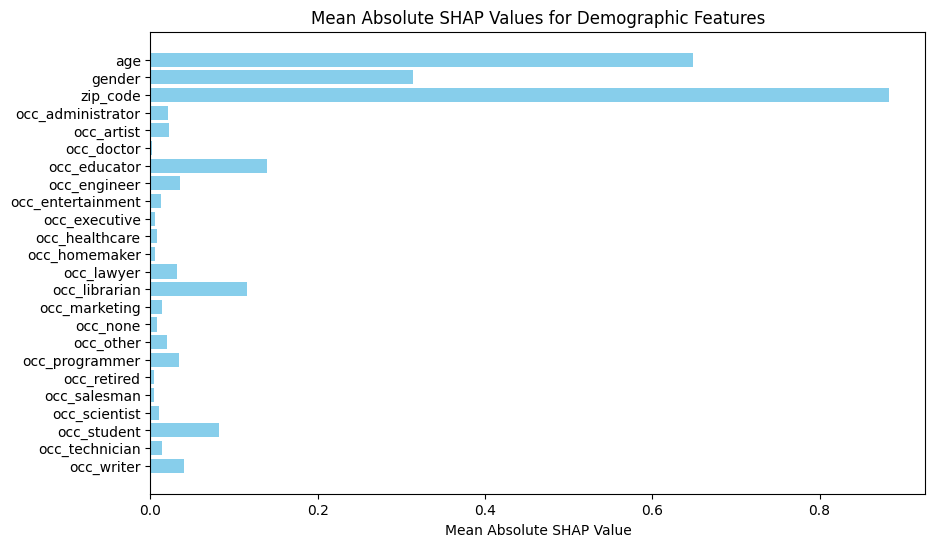

              feature  mean_abs_shap
0                 age       0.649225
1              gender       0.313307
2            zip_code       0.882478
3   occ_administrator       0.020685
4          occ_artist       0.022551
5          occ_doctor       0.002041
6        occ_educator       0.139668
7        occ_engineer       0.034723
8   occ_entertainment       0.013181
9       occ_executive       0.005348
10     occ_healthcare       0.007735
11      occ_homemaker       0.004868
12         occ_lawyer       0.032199
13      occ_librarian       0.115589
14      occ_marketing       0.013290
15           occ_none       0.008285
16          occ_other       0.019712
17     occ_programmer       0.033629
18        occ_retired       0.004637
19       occ_salesman       0.004295
20      occ_scientist       0.009678
21        occ_student       0.081498
22     occ_technician       0.013656
23         occ_writer       0.040620


In [13]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# Step 4: Calculate SHAP Values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X, check_additivity=False)

# Step 5: Calculate the mean absolute SHAP value for each demographic feature
demographic_features = ['age', 'gender', "zip_code"] + [col for col in X.columns if col.startswith('occ_')]
shap_values_demographic = np.abs(shap_values).mean(axis=0)  # Calculate mean absolute SHAP values

print("*************")


shap_df_demographic = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': shap_values_demographic.mean(axis=1) # Take mean across classes to get single value per feature
})

# Filter for just the demographic features
shap_df_demographic = shap_df_demographic[shap_df_demographic['feature'].isin(demographic_features)]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(shap_df_demographic['feature'], shap_df_demographic['mean_abs_shap'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Mean Absolute SHAP Values for Demographic Features')
plt.gca().invert_yaxis()
plt.show()

scaler = MinMaxScaler()
normalized_shap_values = scaler.fit_transform(shap_df_demographic['mean_abs_shap'].values.reshape(-1, 1)).flatten()

# Create weighted features
weighted_features = X[demographic_features] * normalized_shap_values

#shap_df_demographic = pd.DataFrame({'feature': X_train.columns, 'mean_abs_shap': shap_values_demographic[0]})
print(shap_df_demographic)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


x_labels: 
[ 3  0  5  0  1  5  0  2  3  0  1  1  3  3  1  3  3  3  6  2  4  2  1  1
  0  0  6  5  2  3  4  1  5  0  1  1  2  1  3  0  0  5  6  3  5 -1  0  5
  1  4  2  1  2  2  2  2  5  5  5  5  5  1 -1  0  1  4  2  4  3  2  5  1
  3  0  3  4  5  3  1  1  2  5  3  0  5  2  3  6  1  0  0  3  0  3  5  1
  5  1  4  4  2  5  2  2  3  0  5  3  2  4  0  5  0  5  0  3  2  4  0  1
  6  0  1  4  4  1  3 -1 -1  2  0  3  0  2  5  5  2  3  4  1  3  5  5  0
  3  0  6  5 -1  1  1  1  4  4  1  4  0  2  1  5  2  2  0  0  1  2  3  0
  2  0  1  0  0  1  1  4  4  4  3  1  3  3  3  6  6  1  2  4  0  0  0  3
  5  0  2 -1  3  1  5  2  2  1  1  1  4  1 -1  3  1  0  0  1  3  1  4  3
  3  2  0  2  4  3  1  1  1  0  5  1  6  1  2  5  3  0  3  5  5  2  3  1
  1  5  3  3  2  3  4  2  4  0  5  5  1  2  3  2  3  1  4  2  5  1  3  5
  3  0  2  5  6  1  5  5  1  1  2  2  1  6  5  6  1  4  5  3  4  4  4 -1
  2  2  2  3  4  2  5  1  1  3  5  1  2  2  4  1  3  5  3  0  2  3  0  3
 -1  1  0  1  4  0  5  2  1  3  4  1  3 

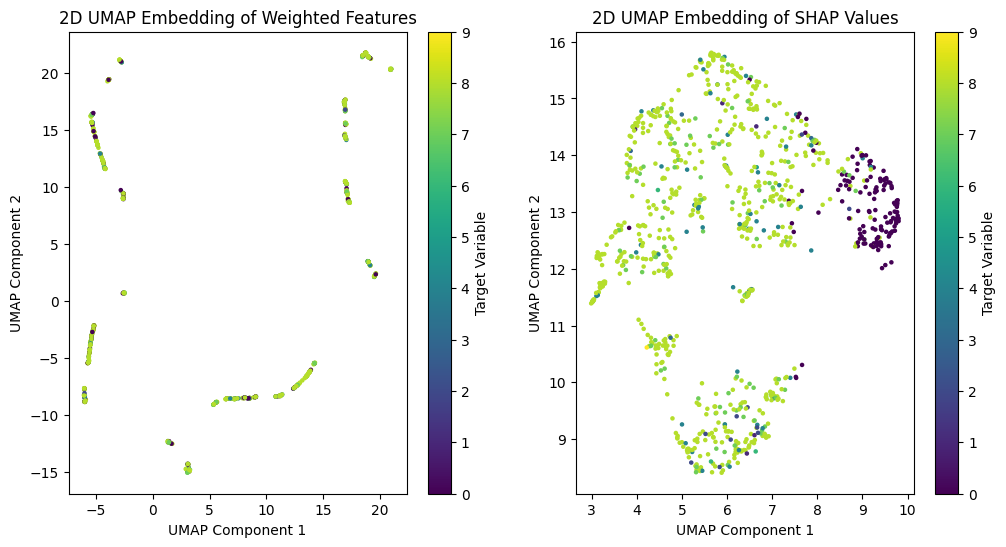

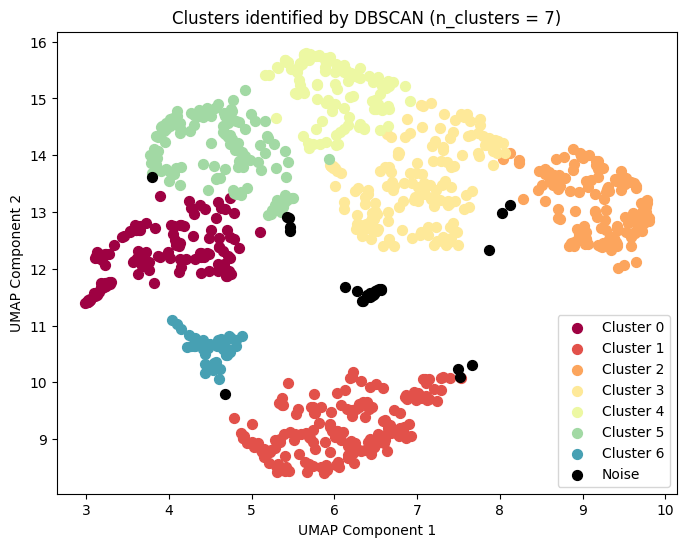

In [40]:
# Perform clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(weighted_features)

# dbscan = DBSCAN(eps=1.5, min_samples=20)
# clusters = dbscan.fit_predict(weighted_features)

# Visualize clusters using UMAP and DBSCAN
X_2d = UMAP(n_components=2, n_neighbors=200, min_dist=0).fit_transform(weighted_features)
s_2d = UMAP(n_components=2, n_neighbors=200, min_dist=0).fit_transform(shap_values[:, :, 0])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_numeric = le.fit_transform(y)


# Plotting the 2D embedding of raw variable values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_numeric, cmap='viridis', s=5)
plt.title('2D UMAP Embedding of Weighted Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Target Variable')

# Plotting the 2D embedding of SHAP values
plt.subplot(1, 2, 2)
plt.scatter(s_2d[:, 0], s_2d[:, 1], c=y_numeric, cmap='viridis', s=5)
plt.title('2D UMAP Embedding of SHAP Values')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Target Variable')

x_labels = DBSCAN(eps=0.62, min_samples=40).fit(s_2d).labels_
print("x_labels: ")
print(x_labels)
plt.figure(figsize=(8, 6))
unique_labels2 = set(x_labels)
print("unique_labels2: ")
print(unique_labels2)
n_clusters_2 = len(unique_labels2) - (1 if -1 in unique_labels2 else 0)
colors2 = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels2)))
#print(unique_labels)
#print(colors)
for k, col in zip(unique_labels2, colors2):
    #print(k)
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (x_labels == k)
    xy = s_2d[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title(f'Clusters identified by DBSCAN (n_clusters = {n_clusters_2})')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

In [37]:
# Step 6: Cluster Users Based on SHAP Values
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

# pca = PCA(n_components=2)
# shap_values_pca = pca.fit_transform(shap_df_demographic.reshape(-1, 1))
# n_clusters = 3
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# clusters = kmeans.fit_predict(shap_values_pca)


# Extract the numerical SHAP values into a NumPy array
shap_values_array = shap_df_demographic['mean_abs_shap'].values.reshape(-1, 1)

pca = PCA(n_components=1)
shap_values_pca = pca.fit_transform(shap_values_array)  # Use the NumPy array here

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(shap_values_pca)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


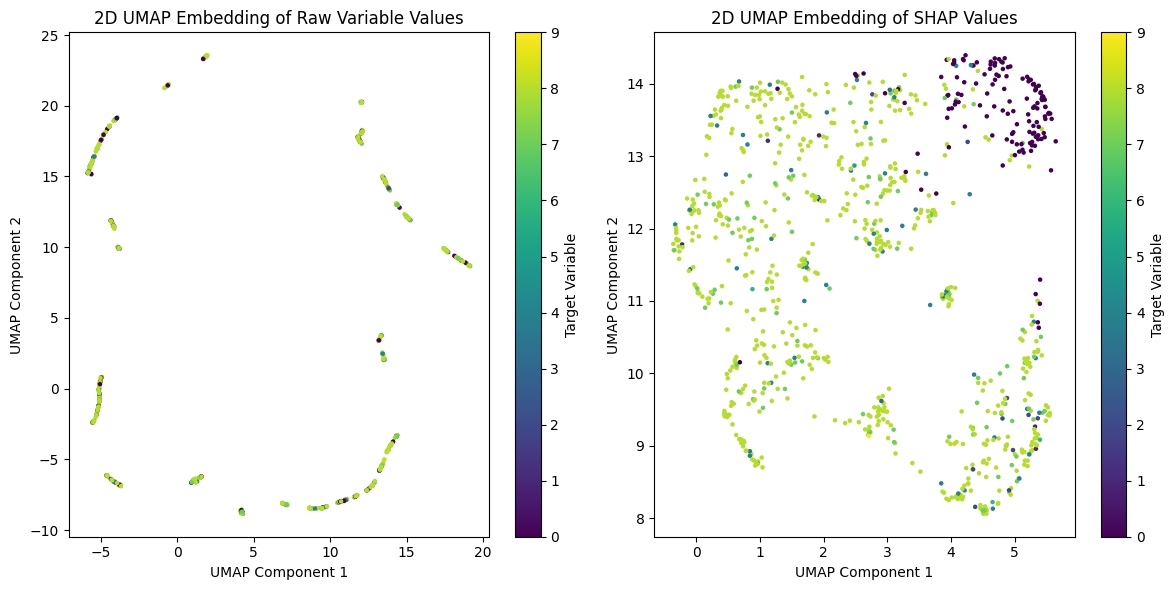

x_labels: 
[ 3  0  4  0  1  4  0  2  3  0  1  1  3  3  1  3  3  3 -1  2  3  2  1  1
  0  0 -1  4  2  3  3  1  4  0  1  1  2  1  3  0  0  4 -1  3  4 -1  0  4
  1  3  2 -1  2  2  2  2  4  4 -1  4  4  1 -1  0  1  3  2  3  3  2  4  1
  3  0  3  3  4  3  1  1  2  4  3  0  4  2  3 -1  1  0  0  3  0  3  4  1
  3  1  3  3  2  4  2  2  3  0  4  3  2  3  0  4  0  4  0  3  2  3  0  1
 -1  0  1  3  3  1  3 -1 -1  2  0  3  0  2  4  4  2  3  3  1  3  4  4  0
  3  0 -1 -1 -1  1  1  1  3  3  1  3  0  2  1  4  2  2  0  0  1  2  3  0
  2  0  1  0  0  1  1  3  3  3  3  1  3  3  3 -1 -1  1  2  3  0  0  0  3
  4  0  2 -1  3  1  4  2  2  1  1  1  3  1 -1  3  1  0  0  1  3  1  3  3
  3  2  0  2  3  3  1  1  1  0  4  1 -1  1  2  4  3  0  2  4  4  2  3  1
  1  4  3  3  2  3  3  2  3  4  4  4  1  2  3  2  3  1  3  2  4  1  3  4
  3  0  2  4 -1  1 -1  4  1  1  2  2  1 -1  4 -1  1  3  4  3  3  3  3 -1
  2  2  2  3  3  2  4  1  1  3  4  1  2  2  3  1  3  4  3  0  2  3  0  3
 -1  1  0  1  3  0 -1  2  1  3  3  1  3 

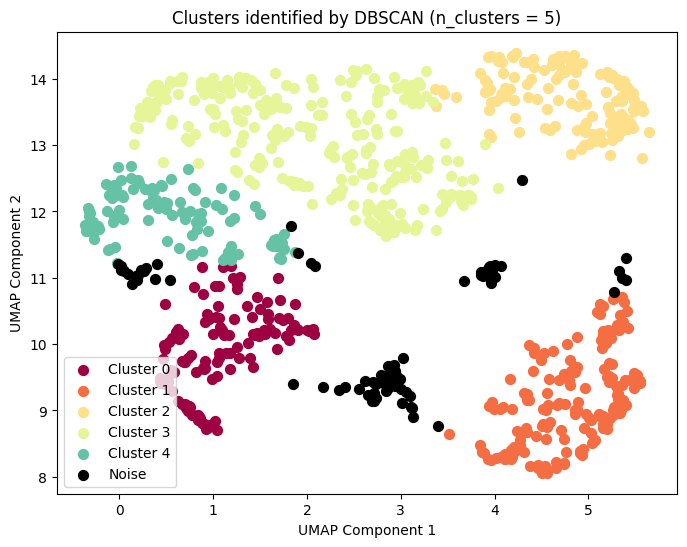

In [38]:
# Step 7: Visualize the Clusters
import matplotlib.pyplot as plt
X_2d = UMAP(
  n_components=2, n_neighbors=200, min_dist=0
).fit_transform(X)

# compute 2D embedding of SHAP values
# Assuming 'shap_values' is a 3D array, select a specific class for visualization
s_2d = UMAP(
  n_components=2, n_neighbors=200, min_dist=0
).fit_transform(shap_values[:, :, 0])  # Select the first class

# Convert genre labels to numerical values for color mapping
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_numeric = le.fit_transform(y)

# Plotting the 2D embedding of raw variable values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_numeric, cmap='viridis', s=5)  # Use y_numeric for color
plt.title('2D UMAP Embedding of Raw Variable Values')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Target Variable')

# Plotting the 2D embedding of SHAP values
plt.subplot(1, 2, 2)
plt.scatter(s_2d[:, 0], s_2d[:, 1], c=y_numeric, cmap='viridis', s=5)  # Use y_numeric for color
plt.title('2D UMAP Embedding of SHAP Values')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Target Variable')

plt.tight_layout()
plt.show()

# Identify clusters using DBSCAN
# s_labels = DBSCAN(eps=3, min_samples=40).fit(s_2d).labels_
# print("s_labels: ")
# print(s_labels)
# # Visualize DBSCAN clusters
# plt.figure(figsize=(8, 6))
# unique_labels = set(s_labels)
# print("unique_labels: ")
# print(unique_labels)
# n_clusters_ = len(unique_labels) - (1 if -1 in unique_labels else 0)
# colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

x_labels = DBSCAN(eps=0.62, min_samples=40).fit(s_2d).labels_
print("x_labels: ")
print(x_labels)
plt.figure(figsize=(8, 6))
unique_labels2 = set(x_labels)
print("unique_labels2: ")
print(unique_labels2)
n_clusters_2 = len(unique_labels2) - (1 if -1 in unique_labels2 else 0)
colors2 = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels2)))
#print(unique_labels)
#print(colors)
for k, col in zip(unique_labels2, colors2):
    #print(k)
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (x_labels == k)
    xy = s_2d[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title(f'Clusters identified by DBSCAN (n_clusters = {n_clusters_2})')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()